In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split

In [2]:
# Reading imbalanced dataset...
with open("cls_dataset.json") as f:
    dataset = json.load(f)

In [3]:
# exploring dataset...
for key in dataset:
    print(f"{key} dataset:")
    print(f'   Number of not useful for learning questions: {dataset[key]["labels"].count(0)}') 
    print(f'   Number of useful for learning questions: {dataset[key]["labels"].count(1)}')

train dataset:
   Number of not useful for learning questions: 2321
   Number of useful for learning questions: 3115
test dataset:
   Number of not useful for learning questions: 81
   Number of useful for learning questions: 119


In [4]:
questions = dataset["train"]["text"] + dataset["test"]["text"]
labels = dataset["train"]["labels"] + dataset["test"]["labels"]
print(f"There are {len(questions)} questions and {len(labels)} labels")

pos_labels = labels.count(1)
neg_labels = labels.count(0)
print(f"There are {pos_labels} positive labels and {neg_labels} negative labels")
print(f"{pos_labels-neg_labels} examples will be deleted to balance the dataset, leaving a dataset length of {neg_labels*2}")

There are 5636 questions and 5636 labels
There are 3234 positive labels and 2402 negative labels
832 examples will be deleted to balance the dataset, leaving a dataset length of 4804


The dataset is imbalanced. Random indices are going to be generated and these questions will be deleted to balance the dataset

In [5]:
from random import seed
import random
seed(42)


# generating random indices to be deleted from train set...
del_pos_indices = []
for _ in range(pos_labels-neg_labels):
    i = random.randint(0, pos_labels)
    while i in del_pos_indices:
        i = random.randint(0, pos_labels)
    del_pos_indices.append(i)


# Information..
print(f"{len(del_pos_indices)} useful question will be deleted from train set")

assert len(del_pos_indices) == pos_labels-neg_labels

832 useful question will be deleted from train set


Deleting questions to balance the dataset

In [6]:
# Formatting the dict into a dataframe to delete both labels and text
df = pd.DataFrame()
df["text"] = questions
df["labels"] = labels

# positive labels from train and test
df_pos = df[df["labels"] == 1]
print(f"There are {len(df_pos)} positive questions ")
# negative labels from train and test
df_neg = df[df["labels"] == 0]
print(f"There are {len(df_neg)} negative questions ")

There are 3234 positive questions 
There are 2402 negative questions 


In [7]:
df_pos.head()

,text,labels
0,"certainly , many algorithms are built complex ...",1
1,but what i would like to ask - what are the al...,1
3,is tere a way to solve a math problem with alg...,1
4,could dna be an algorithm ?,1
17,"at 0:53 , how are algorithms used in rendering ?",1


In [8]:
df_neg.head()

,text,labels
2,is it just based on the length of code ?,0
5,are you just asking what was said ?,0
6,is there a badge for finishing this course ?,0
7,have you looked on your badges page to see if ...,0
8,well that depends : how good are you at maths ?,0


In [9]:
# negative labels list format
balanced_neg_text = list(df_neg["text"].values)
balanced_neg_labels = list(df_neg["labels"].values)

# Removing rows (indices randomly generated)
balanced_pos_text = []
balanced_pos_labels = []

count = 0
for i, (txt, label) in enumerate(zip(df_pos["text"].values, df_pos["labels"].values)):
    if i not in del_pos_indices:
        balanced_pos_text.append(txt)
        balanced_pos_labels.append(label)
    else:
        count += 1

print(f"{len(del_pos_indices)} positive questions have been deleted")
print(f"Now, there are {len(balanced_pos_text)} useful questions for learning and {len(df_neg)} not useful questions for learning")
assert len(balanced_pos_text) == len(balanced_neg_text)

832 positive questions have been deleted
Now, there are 2402 useful questions for learning and 2402 not useful questions for learning


Spitting the 20% from each class to be train and test

In [10]:
split_breakpoint = len(balanced_pos_text)-int(len(balanced_pos_text)*0.2)

# positive labels train split
train_balanced_pos_text = balanced_pos_text[:split_breakpoint]
train_balanced_pos_labels = balanced_pos_labels[:split_breakpoint]

# positive labels test split
test_balanced_pos_text = balanced_pos_text[split_breakpoint:]
test_balanced_pos_labels = balanced_pos_labels[split_breakpoint:]

# negative labels train split
train_balanced_neg_text = balanced_neg_text[:split_breakpoint]
train_balanced_neg_labels = balanced_neg_labels[:split_breakpoint]

# negative labels test split
test_balanced_neg_text = balanced_neg_text[split_breakpoint:]
test_balanced_neg_labels = balanced_neg_labels[split_breakpoint:]

assert len(train_balanced_pos_text) == len(train_balanced_neg_labels)
assert len(test_balanced_neg_labels) == len(test_balanced_pos_labels)

print(f"Train set size: {len(train_balanced_pos_text) + len(train_balanced_neg_labels)}")
print(f"Test set size: {len(test_balanced_neg_labels) + len(test_balanced_pos_labels)}")
print(f"Dataset length: {len(train_balanced_pos_text) + len(train_balanced_neg_labels) + len(test_balanced_neg_labels) + len(test_balanced_pos_labels)}")

Train set size: 3844
Test set size: 960
Dataset length: 4804


Formatting data back to a dict and saving it

In [11]:
# Shuffling balanced train set...
train_balance_df = pd.DataFrame()
train_balance_df["text"] = train_balanced_neg_text + train_balanced_pos_text
train_balance_df["labels"] = train_balanced_neg_labels + train_balanced_pos_labels
train_balance_df = train_balance_df.sample(frac=1).reset_index(drop=True)

# Shuffling balanced test set...
test_balance_df = pd.DataFrame()
test_balance_df["text"] = test_balanced_pos_text + test_balanced_neg_text
test_balance_df["labels"] = test_balanced_pos_labels + test_balanced_neg_labels
test_balance_df = test_balance_df.sample(frac=1).reset_index(drop=True)


In [12]:
train_questions = []
for row in train_balance_df.to_dict()["text"]:
    train_questions.append(train_balance_df.to_dict()["text"][row])
assert len(train_questions) == len(train_balance_df)

train_labels = []
for row in train_balance_df.to_dict()["labels"]:
    train_labels.append(train_balance_df.to_dict()["labels"][row])
assert len(train_labels) == len(train_balance_df)

test_questions = []
for row in test_balance_df.to_dict()["text"]:
    test_questions.append(test_balance_df.to_dict()["text"][row])
assert len(test_questions) == len(test_balance_df)

test_labels = []
for row in test_balance_df.to_dict()["labels"]:
    test_labels.append(test_balance_df.to_dict()["labels"][row])
assert len(test_labels) == len(test_balance_df)

In [13]:
balanced_dataset = {}
balanced_dataset["train"] = {}
balanced_dataset["test"] = {}
balanced_dataset["train"]["text"] = train_questions
balanced_dataset["train"]["labels"] = train_labels
balanced_dataset["test"]["text"] = test_questions
balanced_dataset["test"]["labels"] = test_labels

print(len(train_questions))
print(len(train_labels), )
print(len(test_questions))
print(len(test_labels))

3844
3844
960
960


In [14]:
# exploring dataset...
for key in balanced_dataset:
    print(f"{key} dataset:")
    print(f'   Number of not useful for learning questions: {balanced_dataset[key]["labels"].count(0)}') 
    print(f'   Number of useful for learning questions: {balanced_dataset[key]["labels"].count(1)}')

train dataset:
   Number of not useful for learning questions: 1922
   Number of useful for learning questions: 1922
test dataset:
   Number of not useful for learning questions: 480
   Number of useful for learning questions: 480


In [15]:
with open("cls_balanced_dataset.json", "w") as f:
    json.dump(balanced_dataset, f)
print("cls_balanced_dataset.json successfully generated.")

cls_balanced_dataset.json successfully generated.


In [16]:
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
df_train = pd.DataFrame.from_dict(balanced_dataset["train"])
# df_val = pd.DataFrame.from_dict(dataset["val"])
df_test = pd.DataFrame.from_dict(balanced_dataset["test"])
frames = [df_train, df_test]
df = pd.concat(frames)
i = 1
print(df.shape)
df.head()

(4804, 2)


,text,labels
0,does this also cause the supply curve to shift...,0
1,what does bruce guenther mean here by `` unbra...,0
2,and does n't this put them at risk of discrimi...,0
3,where can i get those math questions ?,0
4,does it really true that higher in speed cost ...,1


c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

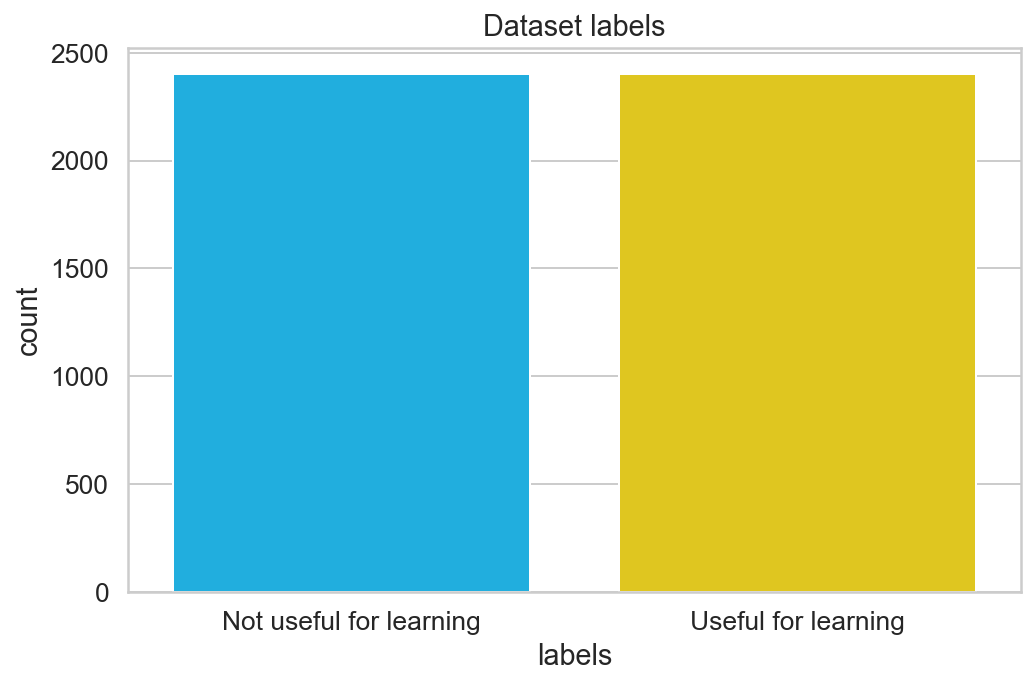

In [18]:
ax = sns.countplot(df.labels)
ax.set_title("Dataset labels")
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels')
ax.set_xticklabels(class_names)

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

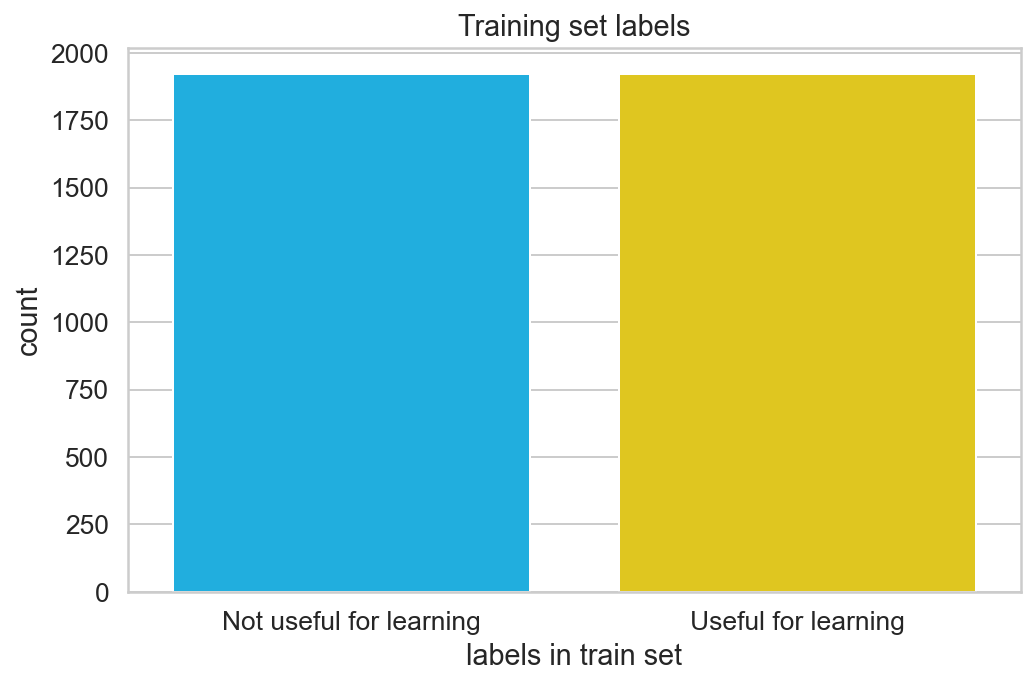

In [19]:
ax = sns.countplot(df_train.labels)
ax.set_title("Training set labels")
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels in train set')
ax.set_xticklabels(class_names)

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

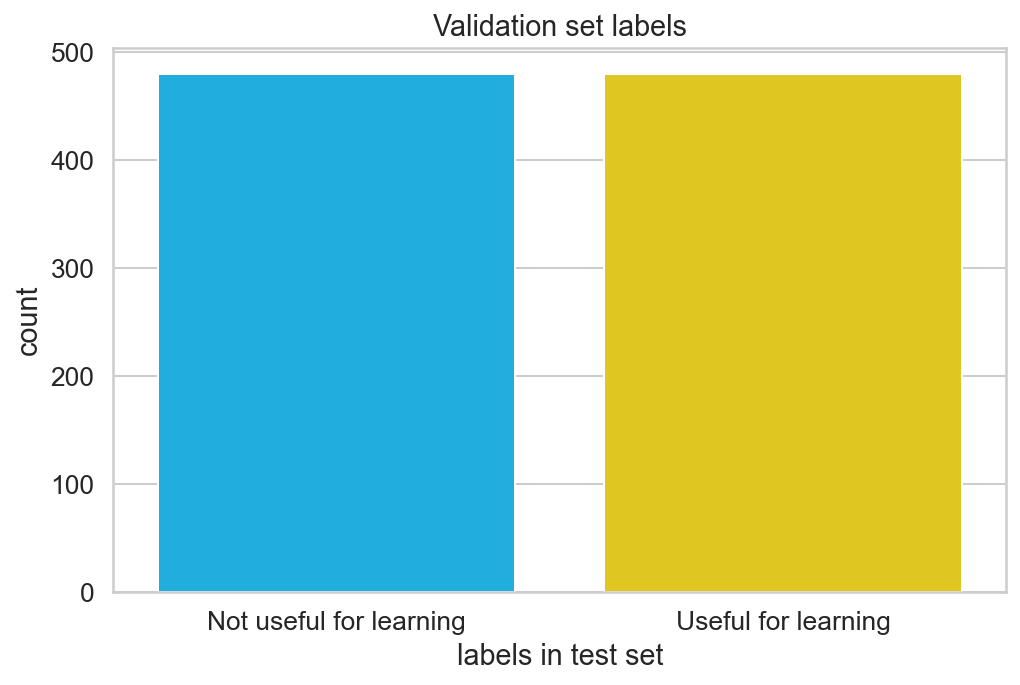

In [20]:
ax = sns.countplot(df_test.labels)
ax.set_title("Validation set labels")
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels in test set')
ax.set_xticklabels(class_names)

In [21]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = dataset["train"]["text"][0]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: \n{sample_txt}')
print(f'   Tokens: \n{tokens}')
print(f'Token IDs: \n{token_ids}')
print(f"SEP token \n{tokenizer.sep_token}, \nsep_token_id {tokenizer.sep_token_id}")
print(f"CLS token \n{tokenizer.cls_token}, \ncls_token_id {tokenizer.cls_token_id}")
print(f"PAD token \n{tokenizer.pad_token}, \npad_token_id {tokenizer.pad_token_id}")
print(f"UNK token \n{tokenizer.unk_token}, \nunk_token_id {tokenizer.unk_token_id}")


 Sentence: 
certainly , many algorithms are built complex and efficient by combining many algorithms into one ( as one step may also be considered an algorithm , is n't it ?
   Tokens: 
['certainly', ',', 'many', 'algorithms', 'are', 'built', 'complex', 'and', 'efficient', 'by', 'combining', 'many', 'algorithms', 'into', 'one', '(', 'as', 'one', 'step', 'may', 'also', 'be', 'considered', 'an', 'algorithm', ',', 'is', 'n', "'", 't', 'it', '?']
Token IDs: 
[4664, 117, 1242, 14975, 1132, 1434, 2703, 1105, 7856, 1118, 12459, 1242, 14975, 1154, 1141, 113, 1112, 1141, 2585, 1336, 1145, 1129, 1737, 1126, 9932, 117, 1110, 183, 112, 189, 1122, 136]
SEP token 
[SEP], 
sep_token_id 102
CLS token 
[CLS], 
cls_token_id 101
PAD token 
[PAD], 
pad_token_id 0
UNK token 
[UNK], 
unk_token_id 100


In [22]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(encoding.keys())
print(len(encoding['input_ids'][0]), encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]), encoding['attention_mask'][0])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])
32 tensor([  101,  4664,   117,  1242, 14975,  1132,  1434,  2703,  1105,  7856,
         1118, 12459,  1242, 14975,  1154,  1141,   113,  1112,  1141,  2585,
         1336,  1145,  1129,  1737,  1126,  9932,   117,  1110,   183,   112,
          189,   102])
32 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
['[CLS]', 'certainly', ',', 'many', 'algorithms', 'are', 'built', 'complex', 'and', 'efficient', 'by', 'combining', 'many', 'algorithms', 'into', 'one', '(', 'as', 'one', 'step', 'may', 'also', 'be', 'considered', 'an', 'algorithm', ',', 'is', 'n', "'", 't', '[SEP]']


c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

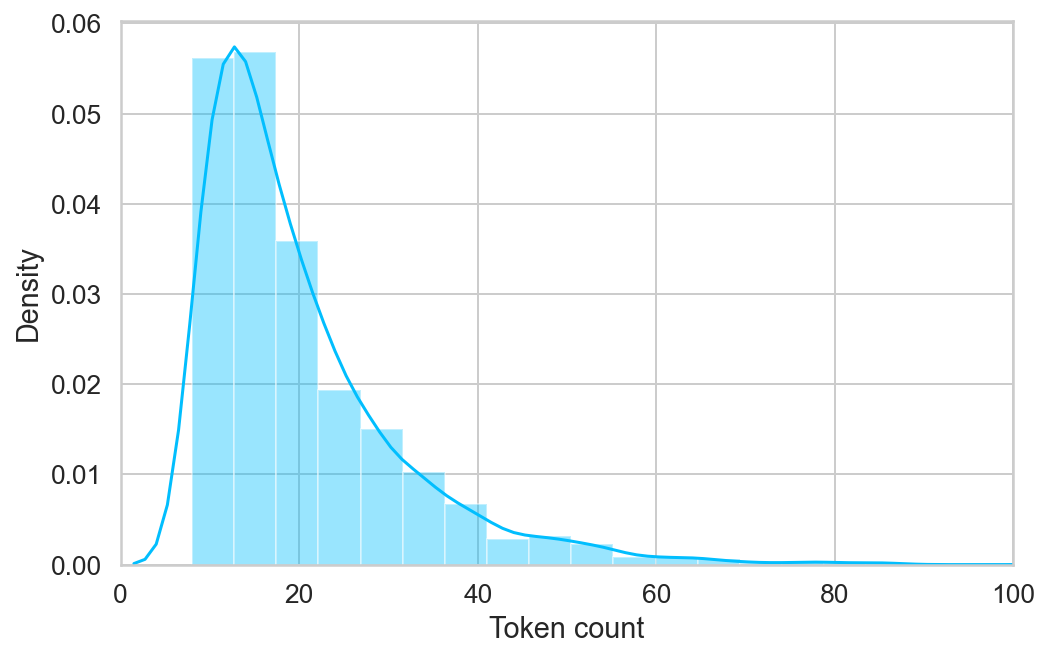

In [23]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')